# Example of Importance Sampling for Bayesian Inference

We want to estimate the posterior distribution of an unknown parameter $\theta$ given the data $D$. That is $p(\theta|D)$.



In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm

plt.rcParams["figure.figsize"] = (20, 15)
plt.rcParams["font.size"] = 16

We define the prior, likelihood and proposal distributions.

$$p(\theta) \qquad p(D|\theta)  \qquad q(\theta)$$

Although the advantage of Monte Carlo is for arbitrary distributions, we are still using Gaussians, so we can compute the exact posterior for comparison.

In [ ]:
# Prior
# m* mean, s* standard deviation
mprior = 1.5
sprior = 1.3
prior = norm(loc=mprior, scale=sprior)

# Likelihood
mlik = 3
slik = 1.5
lik = norm(loc=mlik, scale=slik)

# Proposal
mprop = 1
sprop = 3
proposal = norm(loc=mprop, scale=sprop)

## Importance Sampling
We draw some samples $\theta_i$ from the proposal and weight them. From Bayes Rule we know that:

$$ p(\theta|D) = \frac{p(D|\theta)p(\theta)}{p(D)} $$

Note that $p(D)$ is a constant factor (does not depend on $\theta$) just to make sure that $ \int p(\theta|D) d\theta = 1$.

Thus, we can ignore the constant factor and compute the *unnormalized* weights with just the numerator. Remember that the weight is $ w = \frac{p(\cdot)}{q(\cdot)} $

$$ \widehat{w}_i = \frac{p(D|\theta_i)p(\theta_i)}{q(\theta_i)} $$

Then, we can make sure that the weights are normalized $ \sum w = 1 $ by:

$$ w_i = \frac{\widehat{w}_i}{\sum_j \widehat{w}_j} $$

In [ ]:
# Importance sampling
# We are able to approximate the posterior, without computing the posterior!
samples = np.random.normal(mprop, sprop, 5000)

weights = prior.pdf(samples) * lik.pdf(samples)  / proposal.pdf(samples)
weights /= sum(weights)

print("Mean of the posterior with Monte Carlo:", np.sum(weights*samples)/np.sum(weights))

Mean of the posterior with Monte Carlo: 2.15312192061758


Because everything is Gaussian, we can compute the posterior exactly. This is only for comparison.

In [ ]:
# Posterior (Bayes Rule)
# This is only use for plotting. The samples doesn't use this.
# We use the precision, instead of the variance, lambda = 1/sigma^2
lprior = 1/sprior**2
llik = 1/slik**2
lpost = lprior + llik

mpost = (mlik*llik + mprior*lprior) / lpost
spost = 1/np.sqrt(lpost)

print("True mean of the posterior", mpost)

True mean of the posterior 2.1434010152284264


We plot the distributions and the Monte Carlo samples as a histogram.

In [ ]:
# Just for plotting
def plot_gaussian(ax, mu, sigma, color='b'):
  X = np.linspace(-3, 8, 500)
  rv = norm(loc=mu, scale=sigma)
  ax.plot(X, rv.pdf(X), color)

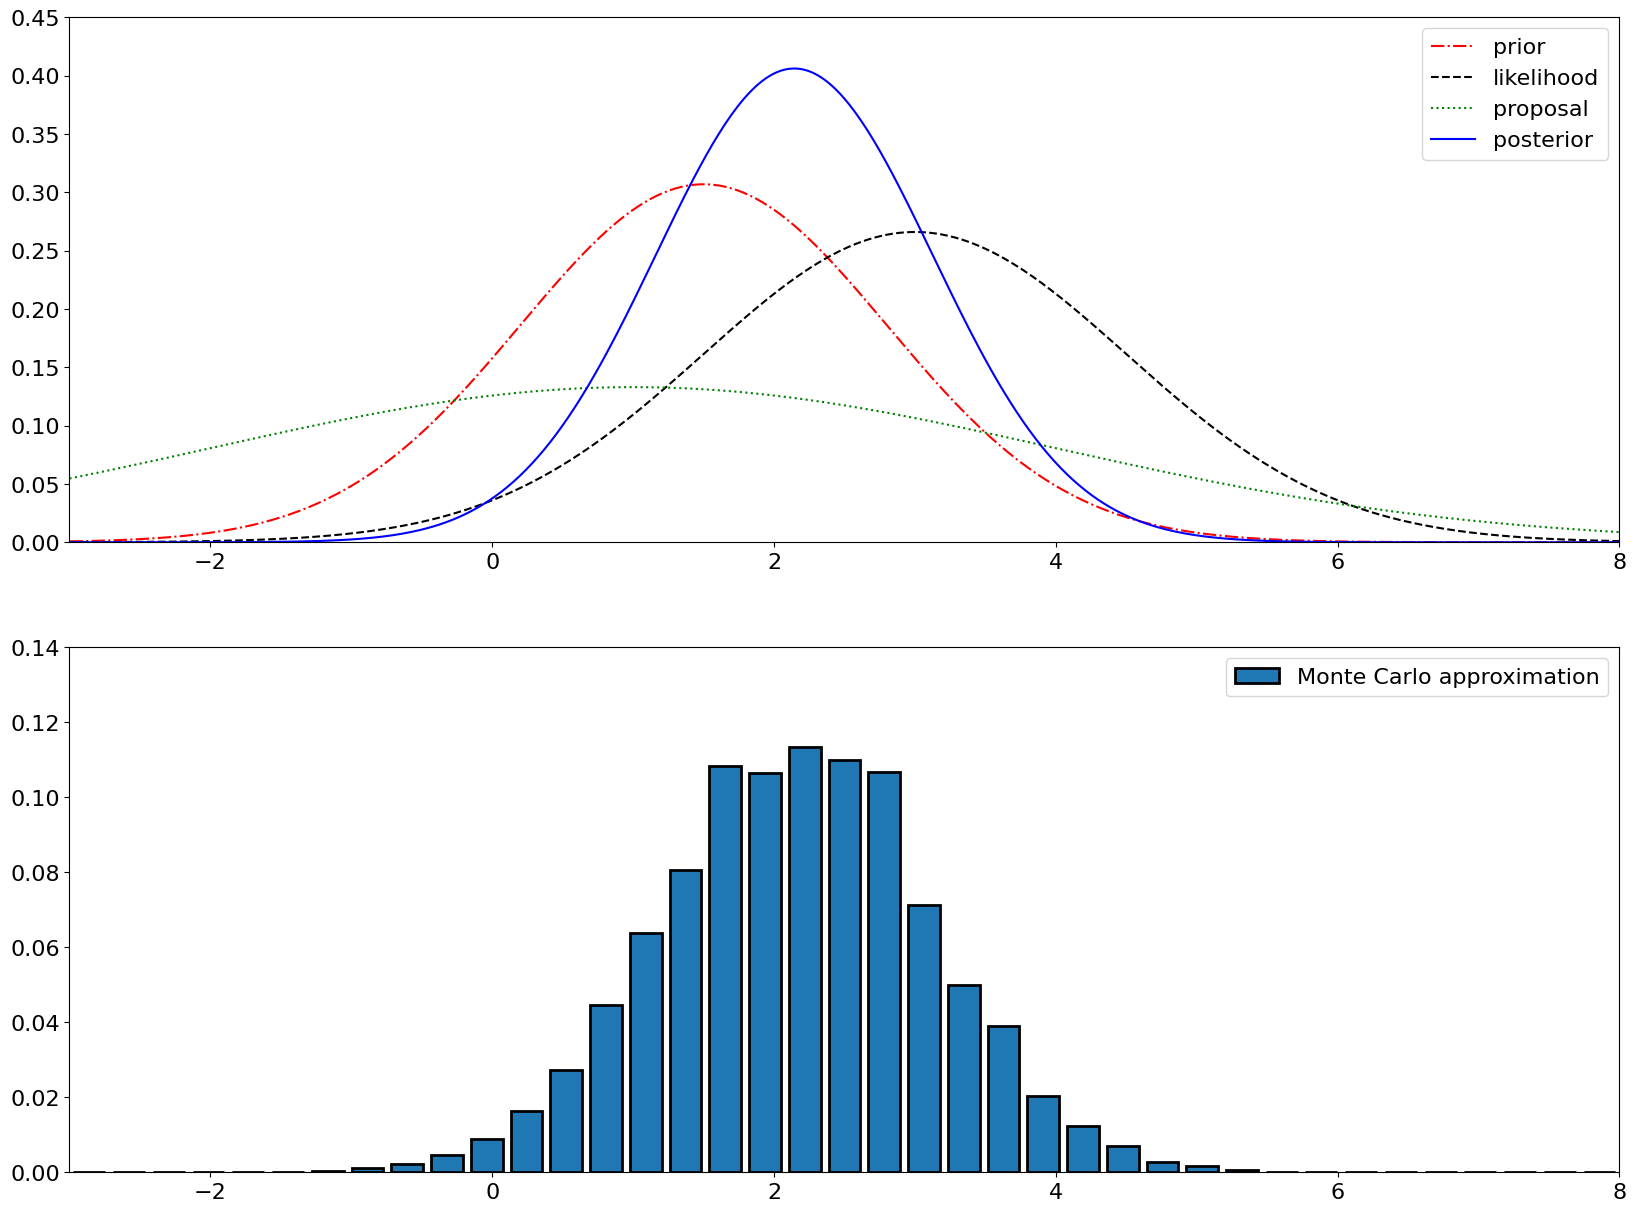

In [ ]:
fig, (ax1, ax2) = plt.subplots(2, 1)
plot_gaussian(ax1, mprior, sprior, 'r-.')
plot_gaussian(ax1, mlik, slik, 'k--')
plot_gaussian(ax1, mprop, sprop, 'g:')
plot_gaussian(ax1, mpost, spost, 'b')
ax1.legend(["prior", "likelihood", "proposal", "posterior"])
ax1.axis([-3, 8, 0, 0.45])

# The vertical axis does not much because we are plotting the weighted histogram.
# The value depends on the number of samples per bin, which depends on the number of bins.
ax2.hist(samples,bins=np.linspace(-3, 8, 40),weights=weights, rwidth=0.8, edgecolor='black', linewidth=2)
ax2.legend(["Monte Carlo approximation"])
ax2.axis([-3, 8, 0, 0.14])

plt.show()

## Bayesian logistic regression

Now we are going to do something similar but with a real problem of logistic regression. Now, the likelihood is a bernoilli distribution on the logistic function.

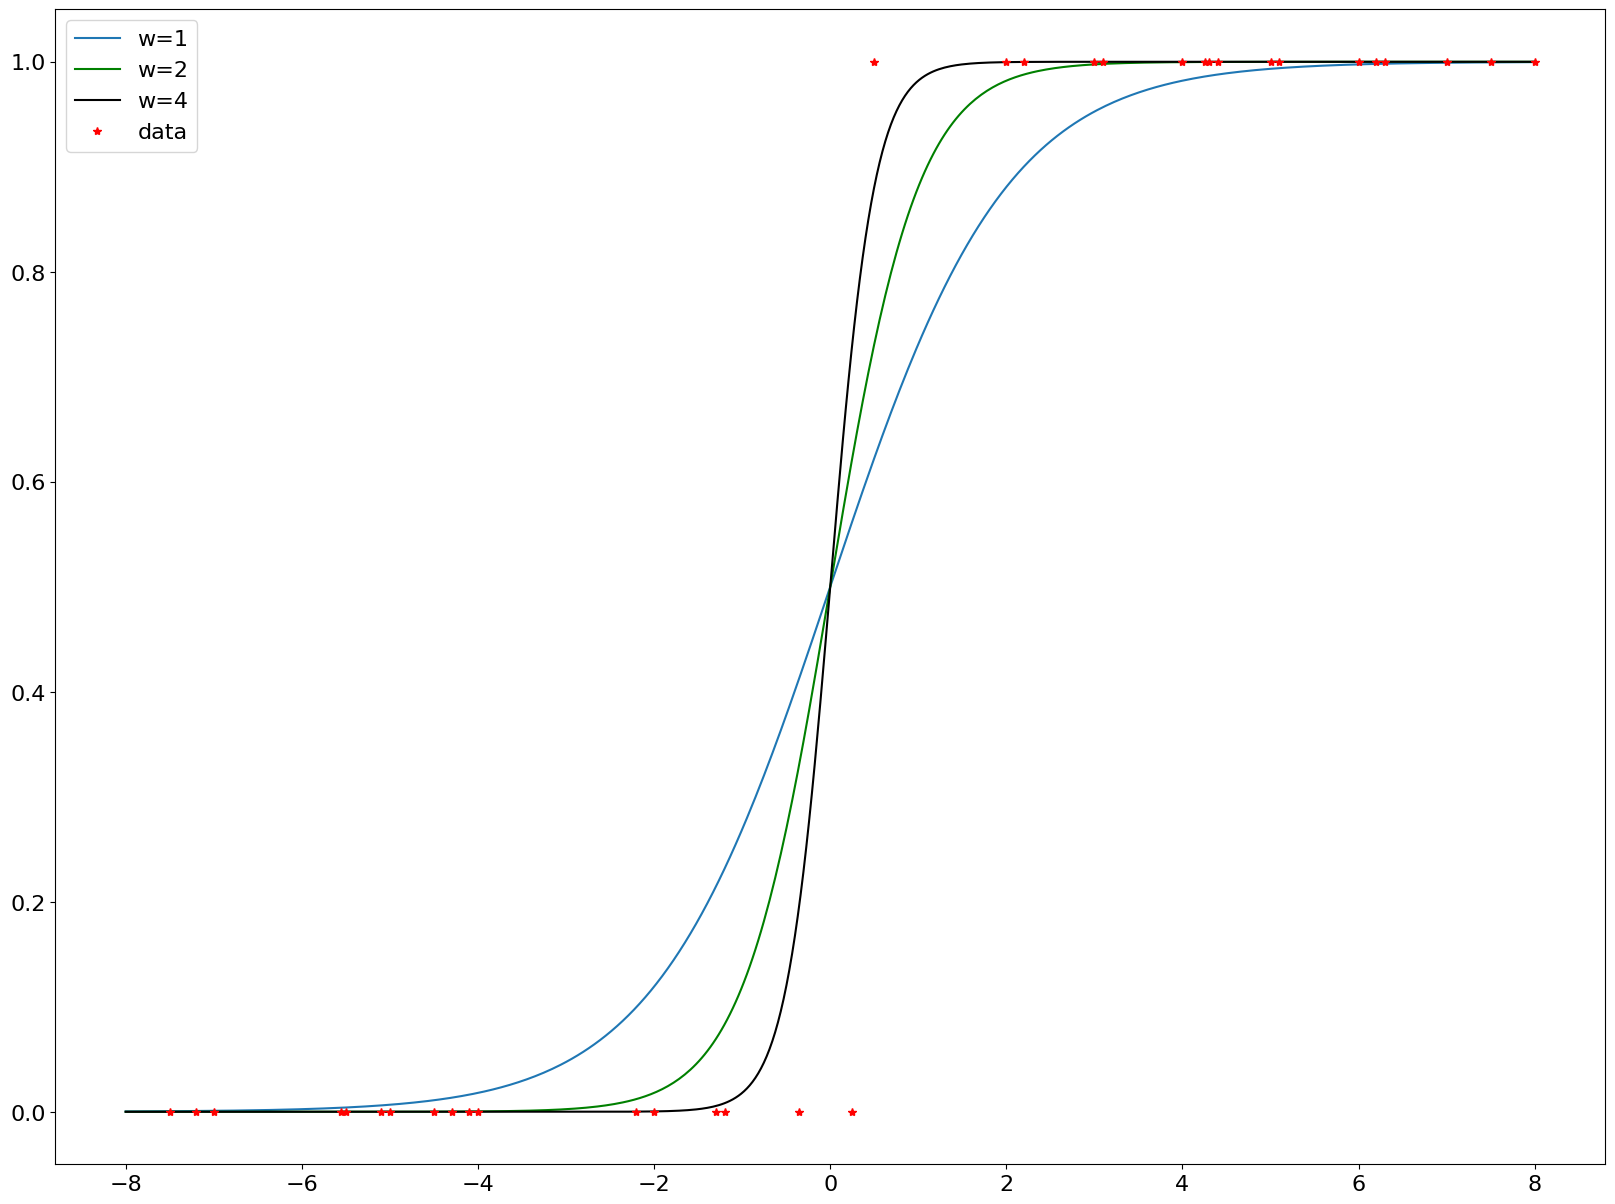

In [ ]:
from scipy.special import expit
from scipy.stats import bernoulli

# Likelihood from true data (generated from the actual Bernouilli distribution)
xd = [-5, -7, -7.5, -7.2, -4, -5.5, -4.5, -2, 2, 4, 5, 6, 4.4, .5, -1.3, -1.2, 3, -5.1, -4.1, -5.55, -4.3, -2.2, 2.2, 4.3, 5.1, 6.2, 4.25, .25, -0.35, 8, 3.1, 7, 7.5, 6.3]
#yd = [bernoulli.rvs(expit(xi*2)) for xi in xd]
yd = [0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1]

def f_likelihood(w):
  prob = 1
  for xi, yi in zip(xd,yd):
    prob *= bernoulli.pmf(yi, expit(xi*w))
  return prob

# Prior
mprior = 0
sprior = 1.3
prior = norm(loc=mprior, scale=sprior)

# Proposal
mprop = 0
sprop = 3
proposal = norm(loc=mprop, scale=sprop)

x = np.linspace(-8, 8, 500)

plt.figure()
plt.plot(x,expit(x))
plt.plot(x,expit(x*2),'g')
plt.plot(x,expit(x*4),'k')
plt.plot(xd,yd,'r*')
plt.legend(["w=1", "w=2", "w=4", "data"])

In this case, the posterior distribution does not have a closed form. But we are still able to plot the results because plots are, in fact, grid approximations.

<function matplotlib.pyplot.show(close=None, block=None)>

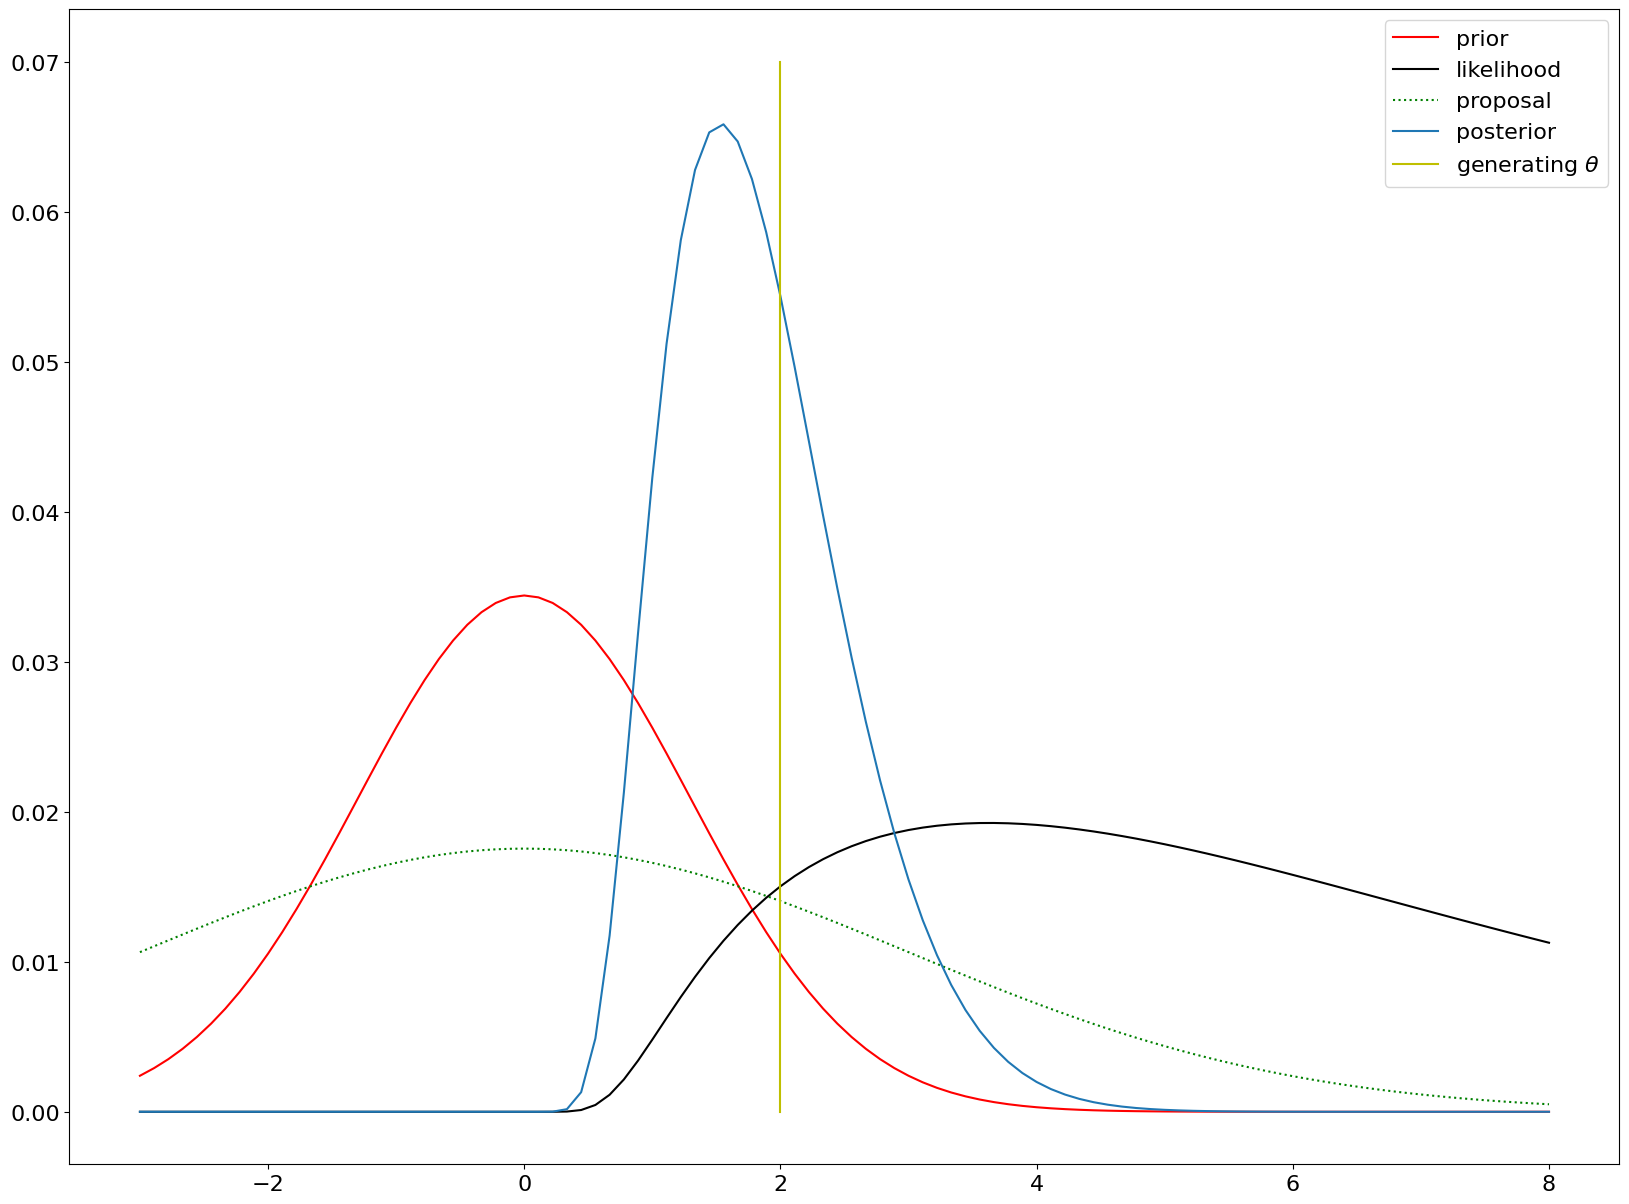

In [ ]:
wplot = np.linspace(-3,8,100)

# Unnormalized likelihood
ylik = np.ones(wplot.shape)
for i,w in enumerate(wplot):
  ylik[i] = f_likelihood(w)

# Prior
yprior = prior.pdf(wplot)

# Proposal
yprop = proposal.pdf(wplot)

# Unnormalized posterior
ypost = ylik*yprior

plt.figure()

# We rescale of the plots to be relatively consistent, but this scale is not
# accurate. It is only for visualization.
yprior /= sum(yprior)
ylik /= sum(ylik)
ypost /=sum(ypost)
yprop /=sum(yprop)


plt.plot(wplot, yprior, 'r')
plt.plot(wplot, ylik, 'k')
plt.plot(wplot, yprop, 'g:')
plt.plot(wplot, ypost)

plt.plot([2, 2],[0, 0.07],'y')
plt.legend(["prior", "likelihood", "proposal", "posterior", r'generating $\theta$'])

plt.show

Mean of the posterior with Monte Carlo: 1.8422065630486588


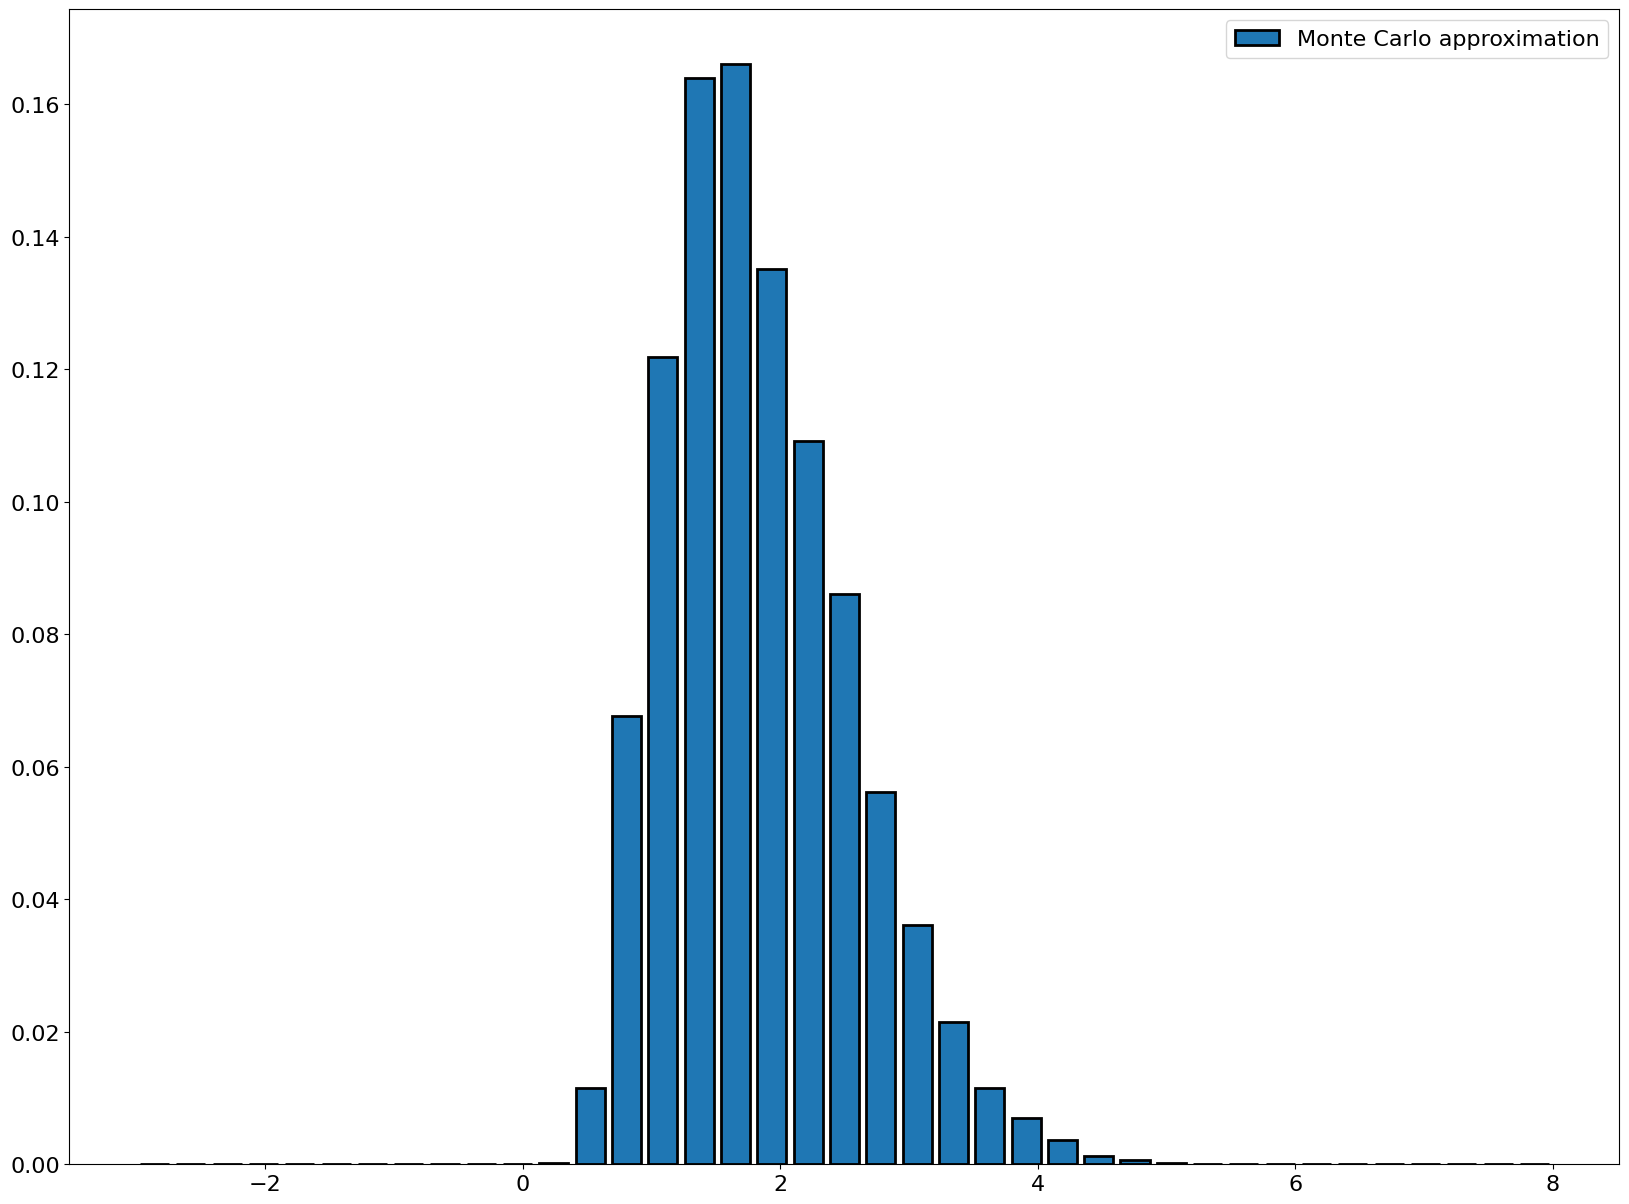

In [ ]:
# Importance sampling
# We are able to approximate the posterior, without computing the posterior!
samples = np.random.normal(mprop, sprop, 5000)

weights = prior.pdf(samples) * f_likelihood(samples)  / proposal.pdf(samples)
weights /= sum(weights)

print("Mean of the posterior with Monte Carlo:", np.sum(weights*samples)/np.sum(weights))

# The vertical axis does not much because we are plotting the weighted histogram.
# The value depends on the number of samples per bin, which depends on the number of bins.
plt.hist(samples,bins=np.linspace(-3, 8, 40),weights=weights, rwidth=0.8, edgecolor='black', linewidth=2)
plt.legend(["Monte Carlo approximation"])

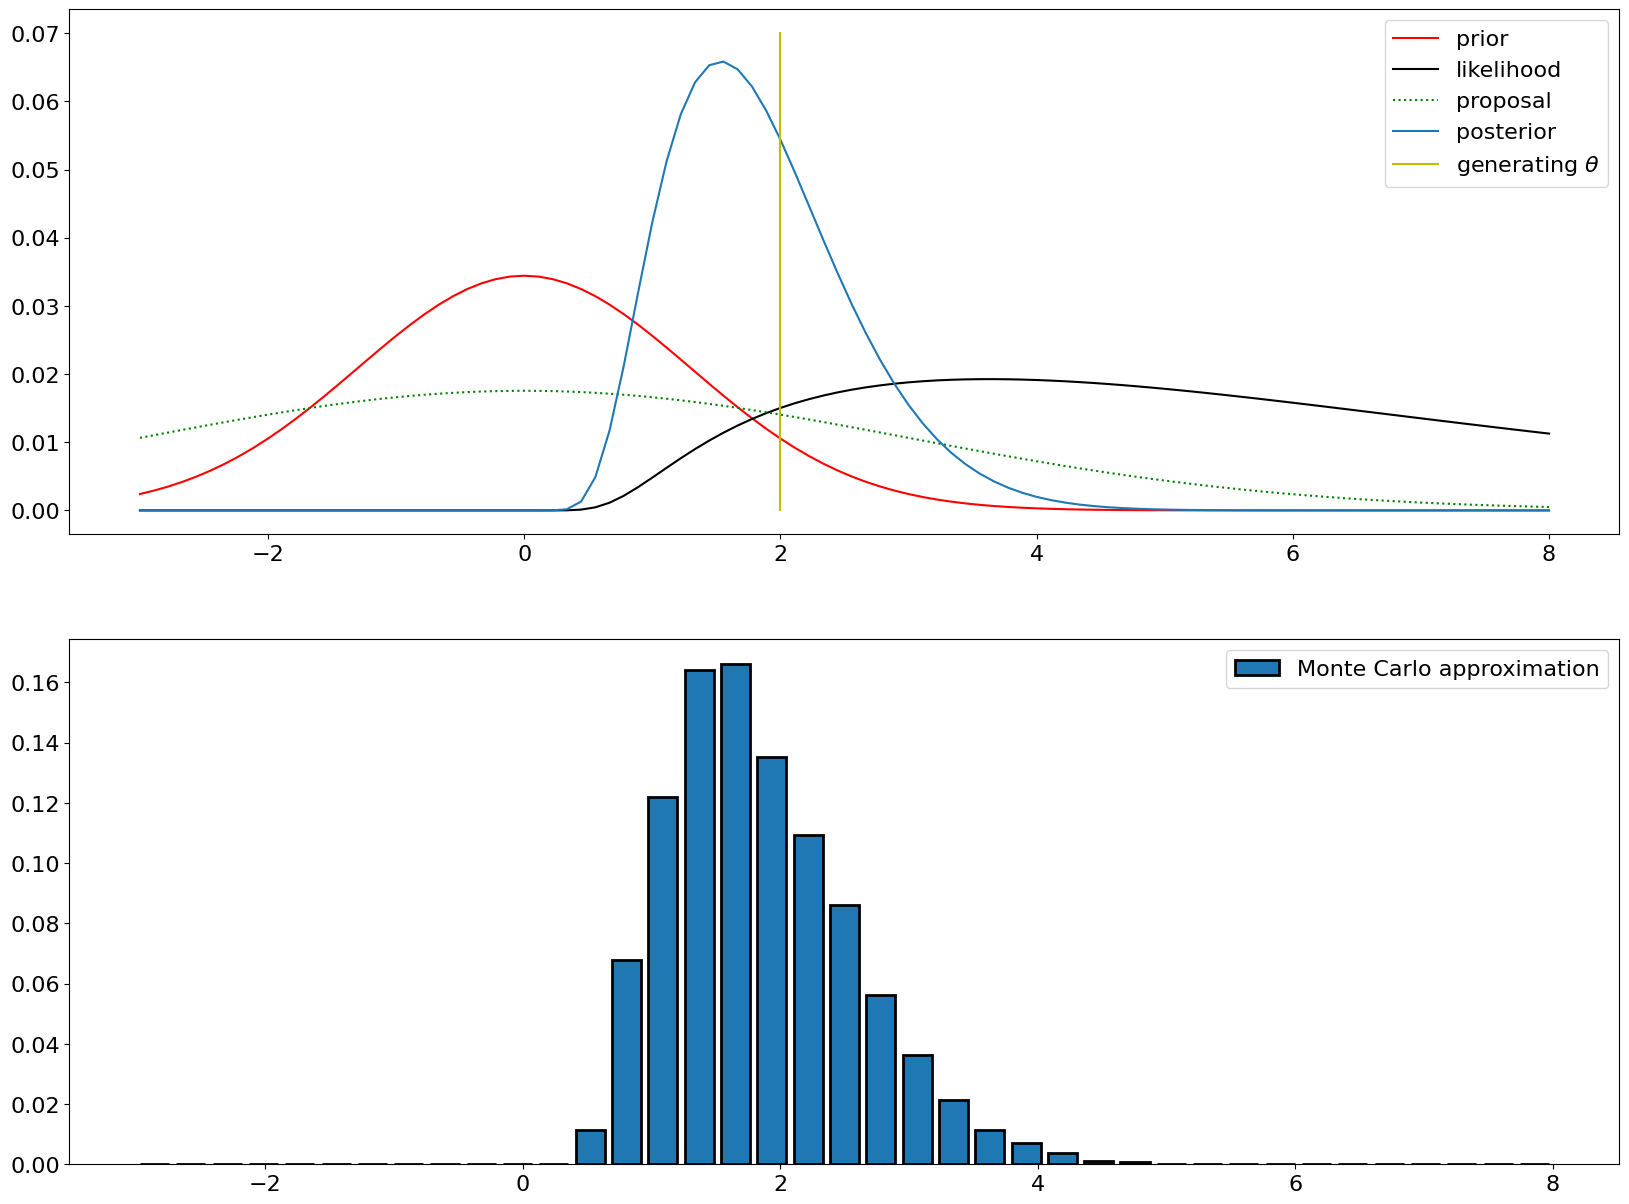

In [ ]:
fig, (ax1, ax2) = plt.subplots(2, 1)
ax1.plot(wplot, yprior, 'r')
ax1.plot(wplot, ylik, 'k')
ax1.plot(wplot, yprop, 'g:')
ax1.plot(wplot, ypost)

ax1.plot([2, 2],[0, 0.07],'y')
ax1.legend(["prior", "likelihood", "proposal", "posterior", r'generating $\theta$'])

# The vertical axis does not much because we are plotting the weighted histogram.
# The value depends on the number of samples per bin, which depends on the number of bins.
ax2.hist(samples,bins=np.linspace(-3, 8, 40),weights=weights, rwidth=0.8, edgecolor='black', linewidth=2)
ax2.legend(["Monte Carlo approximation"])

plt.show()